ResNet is short name for Residual Network. As the name of the network indicates, this new terminology introduces residual learning.

In general, in a deep convolutional neural network, several layers are stacked and are trained to the task at hand. The network learns several low/mid/high level features at the end of its layers. In residual learning, instead of trying to learn some features, we try to learn some residual. Residual can be simply undestood as subraction of feature learned from input of that layer. ResNet does this using shortcut connections(directly connecting input of nth layer to some (n+x)th layer. It has proved that training this from of networks are easier than traning ismple deep convolutional neural networks and also the problem of degrading accuracy is resolved.

### **Need of Residual Learning:**

Deep Convolution Neural Networks have led to a series of breakthrough for image classification. Many other visual recognition tasks have also greatly benefited from very deep models. So, over the years there is a trend to go more deeper, to solve more complex tasks and to also increase/improve the classification/recognition accuracy. But, as we go deeper; the traning of neural network becomes difficult and also the accuracy starts saturating and then degrades also. Residual Learning tries to solve both these problems.

Here, for classification of Devanagari Handwritten digits (a.k.a. Nepali handwritten digits) ResNet50 network architecture is used.

ResNet50 is a 50 layer Residual Network. For further description about the architecture you can <a href="https://arxiv.org/pdf/1512.03385.pdf">click here.</a>


## Importing Libraries

In [0]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn.functional as F
from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

## Mounting Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Runtime Type to GPU

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Creating Train/Test Directory

In [0]:
!mkdir Train
!mkdir Test

## Extracting the Train/Test from drive

In [0]:
!tar -xf "gdrive/My Drive/Colab Notebooks/devnagari/dataset/Train.tar.xz" -C "Train"
!tar -xf "gdrive/My Drive/Colab Notebooks/devnagari/dataset/Test.tar.xz" -C "Test"

In [0]:
# CSV file path which contains Image name and respective image label
train_csv_path = "Train/trainset.csv"
test_csv_path = "Test/testset.csv"

In [0]:
# Reading CSV contents using pandas as pandas' dataframe
train_set_df = pd.read_csv(train_csv_path)
test_set_df = pd.read_csv(test_csv_path)

## Data Preprocessing

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
# converting pandas dataframe into numpy arrays
train_set_array = train_set_df.values
test_set_array = test_set_df.values

# initializing the instance of LabelEncoder
labelEncode = LabelEncoder()

# Encoding the labels
train_set_array[:, 1] = labelEncode.fit_transform(train_set_array[:, 1])
test_set_array[:, 1] = labelEncode.fit_transform(test_set_array[:, 1])

In [0]:
# Converting numpy array back to pandas dataframe
train_set = pd.DataFrame(train_set_array)
print("Trainset shape is: ", train_set.shape)

Trainset shape is:  (78199, 2)


In [0]:
# Counting number of data available for each label
# Making sure that the available data is uniformly distributed
pd.value_counts(train_set[1].values, sort=False)

In [79]:
test_set = pd.DataFrame(test_set_array)
print("Testset Shape is: ", test_set.shape)
test_set.tail()

Testset Shape is:  (27599, 2)


,0,1
27594,56844.png,45
27595,99796.png,45
27596,99777.png,45
27597,99786.png,45
27598,68544.png,45


## Validation Dataset

In [0]:
# selecting 25% random sample from train dataset
val_set = train_set.sample(frac=0.25)

The mean of the distribution is:  425.0
The standard deviation is:  14.62114146630754
The median of dataset is:  426.0
The mode of dataset is:  0    420
1    422
2    429
3    430
4    439
dtype: int64
The Range of distribution is:  79


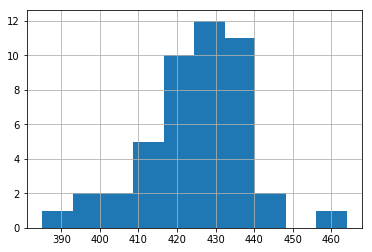

In [0]:
each_class_values = pd.value_counts(val_set[1].values, sort=True)
print("The mean of the distribution is: ", each_class_values.mean(axis=0))
print("The standard deviation is: ", each_class_values.std(axis=0))
print("The median of dataset is: ", each_class_values.median(axis=0))
print("The mode of dataset is: ", each_class_values.mode())
print("The Range of distribution is: ", each_class_values.max() - each_class_values.min())
each_class_values.hist()

In [0]:
# removing the data from Train set that are taken for validation
train_set = train_set.drop(val_set.index)

In [0]:
print("Validation Set Shape is: ", val_set.shape)

Validation Set Shape is:  (19550, 2)


## Image Manipulation/Data Augmentation

In [0]:
# Location of Images of Train & Test sets.
TRAIN_DATA_PATH = "Train/trainset"
TEST_DATA_PATH = "Test/testset"

In [0]:
# Data augmentation
# Normalization metrics are taken from ImageNet documentation
# Dataset is in Grayscale with 1 channel
# Converting the grascale with 1 channel into 3 channels
# ResNet50 architecture needs 3 image channels as input

TRANSFORM_IMG_train = transforms.Compose([
      transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225])
])

TRANSFORM_IMG_test = transforms.Compose([
      transforms.Grayscale(num_output_channels=3),
      transforms.ToTensor(),
      transforms.Normalize(mean = [0.485, 0.456, 0.406],
                          std = [0.229, 0.224, 0.225])
])

## Conversion of Image into Tensor

In [0]:
# Loading images and their label as tensor
# converting image to tensor using PIL.Image

class Devanagari_Data_Load(Dataset):

  def __init__(self, data_dir_path, pd_df, img_transform):
    self.data_dir_path = data_dir_path
    self.df = pd_df
    self.img_transform = img_transform

  # required for shuffling
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    df_row = self.df.iloc[index, :]
    img_name = df_row[0]
    img_path = os.path.join(self.data_dir_path, img_name)
    image = Image.open(img_path)
    image = self.img_transform(image)
    label = df_row[1]
    return (image, label)

In [0]:
# converting images into tensor data of image and label
train_dataset = Devanagari_Data_Load(TRAIN_DATA_PATH, train_set, TRANSFORM_IMG_train)
val_dataset = Devanagari_Data_Load(TRAIN_DATA_PATH, val_set, TRANSFORM_IMG_test)
test_dataset = Devanagari_Data_Load(TEST_DATA_PATH, test_set, TRANSFORM_IMG_test)

In [0]:
# creating iterator object of DataLoader for creating batchsize
# assigning 8 cores with data shuffling
batch_size = 16
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True,  num_workers=4)


### ResNet50 Model

In [0]:
# using resnet50 pretrained architecture to train model
model = models.resnet50(pretrained=True)

# modifying output fully connected layer to our requirement.
model.fc.out_features = 46

# assigning model to GPU
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 54.5MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Initializing Parameters


In [0]:
epochs = 10
losses = nn.CrossEntropyLoss()
learning_rate = 1.5e-6
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

## Loss and Accuracy

In [0]:
def evaluationMetrics(model, data_loader):

  model.eval()
  total_loss = 0
  total_correct = 0

  for i, (img, lbl) in enumerate(data_loader):

    correct = 0

    img = img.to(device)
    lbl = lbl.to(device)

    forwardPass = model.forward(img)
    modelLoss = losses(forwardPass, lbl).item()
    total_loss += modelLoss

    max_val, predict_class = torch.max(forwardPass.data, 1)
    correct = (predict_class == lbl).sum().item() / len(lbl)
    total_correct += correct

  return (total_loss/len(data_loader) , (total_correct/len(data_loader)*100))

## Image Properties and Shapes

In [0]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
print("The shape of image: {} with batchsize: {} ".format(images.shape, batch_size))
print("THe shape of label: ", labels.shape)

The shape of image: torch.Size([16, 3, 32, 32]) with batchsize: 16 
THe shape of label:  torch.Size([16])


## Training the Model

In [0]:
def trainModel(model, optimizer, losses, train_data_loader, epochs):
  model.train()

  info_all = []
  
  for epoch in range(epochs):
    train_correct = 0
    for i, (images, labels) in enumerate(train_data_loader):
      correct = 0
      # clear gradients
      optimizer.zero_grad()

      # assigning data and lables to device
      images = images.to(device)
      labels = labels.to(device)

      # Forward Propagation
      outputs = model.forward(images)

      # calculating loss with softwax to obtain cross entropy loss
      loss = losses(outputs, labels)

      # Backward propagation
      loss.backward()

      # Updating gradients
      optimizer.step()
    
    # Looking for loss and accuracy in entire validation set and train set
    train_loss, train_acc = evaluationMetrics(model, train_data_loader)
    val_loss, val_acc = evaluationMetrics(model, val_data_loader) 

    # creating a list with info of training and validation, loss and accuracy for each epoch
    # useful for plotting the curve of epoch vs loss/accuracy

    for_plot = {
        "epoch": epoch+1,
        "train_loss":train_loss,
        "train_accuracy": train_acc,
        "val_loss":val_loss,
        "val_accuracy":val_acc
    }
    info_all.append(for_plot)

    # switiching back train mode
    # as it was switched to evaluation mode during evaluating Loss & accuracy
    model.train()

    print('Epoch [{}/{}], TrainingLoss: {:.4f}, TrainingAccuracy: {:.2f}%, ValLoss:{:.4f}, ValAccuracy:{:.2f}%'
      .format(epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))
    
    # Saving the model for each epoch
    checkpoint = {
        'model': model,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(checkpoint, 'devanagari_resnet50_v1.3-epoch{}.pth'.format(epoch+1))
    
  return (model, optimizer, info_all)

In [0]:
(trained_model, optimizer, info_all) = trainModel(model, optimizer, losses, train_data_loader, epochs)

## Saving Model

In [0]:
# creating a checkpoint dictionary, saving model and its state & optimizer state as well
# saving dictionary to file, extension .pth, .pt, .pkl

checkpoint = {
    'model': trained_model,
    'state_dict': trained_model.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(checkpoint, 'devanagari_resnet50_v1.3.pth')

## Loading Saved Model

In [0]:
# creating model from saved state and switching it to evaluation mode for inference

def load_checkpoint(model_path):
  checkpoint = torch.load(model_path)
  model = checkpoint["model"]

  model.load_state_dict(checkpoint["state_dict"])

  for parameter in model.parameters():
    parameter.requires_grad=False
  
  model.eval()
  return model

my_model = load_checkpoint("devanagari_resnet50_v1.3.pth")

## Test Model with TestSet

In [0]:
# calculating testset accuracy
all_prediction = []
all_label = []
correct = 0
for i, (img, lbl) in enumerate(test_data_loader):
  image = img.to(device)
  label = lbl.to(device)

  output = my_model.forward(image)

  max_val, prediction = torch.max(output.data, 1)

  #correct += ((prediction==label).sum().item()) / len(label)
  correct += (prediction.eq(label).sum().item()) / len(label)
  all_prediction.append(prediction)
  all_label.append(label)
print("Test Accuracy: ", correct/len(test_data_loader)*100)

Test Accuracy:  99.05797101449275


# Checking for New image

In [0]:
!mkdir check

The prediction class of the Image is:  45


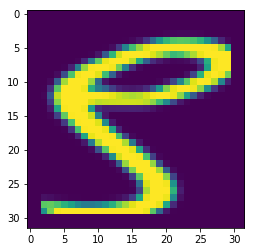

In [86]:
img_path = "check/56844.png"

image = Image.open(img_path)
plt.imshow(image)
# Transformation as defined above
transform = transforms.Compose([
  transforms.Grayscale(num_output_channels=3),
  transforms.ToTensor(),
  transforms.Normalize(mean = [0.485, 0.456, 0.406],
                      std = [0.229, 0.224, 0.225])
])
# applying transformation to image
imageTensor = transform(image)

image = imageTensor.to(device)
image.unsqueeze_(0)

output = my_model.forward(image)

max_val, prediction = torch.max(output.data, 1)

print("The prediction class of the Image is: ", prediction.item())
# Here class 45 is "nau"; model predicted correct.

In [0]:
# Combining all the prediction to a single array for ploting confusion matrix
all_prediction_array = []
for i in range(len(all_prediction)):
  all_prediction_array.append(all_prediction[i].cpu().numpy().tolist())

flat_list_prediction = []
for sublist in all_prediction_array:
    for item in sublist:
        flat_list_prediction.append(item)

In [0]:
# Combining all the Target values (Labels) to a single array
all_label_array = []
for i in range(len(all_label)):
    all_label_array.append(all_label[i].cpu().numpy().tolist())

flat_list_label = []
for sublist in all_label_array:
    for item in sublist:
        flat_list_label.append(item)

## Plotting Graph

In [0]:
# Extracting information of training and validation set from info_all dictionary
# it contains train and test loss/accuracy for each epoch
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in info_all:
  val_loss.append(i["val_loss"])
  val_acc.append(i["val_accuracy"])
  train_loss.append(i["train_loss"])
  train_acc.append(i["train_accuracy"])

### Epoch vs Loss

In [0]:
plt.figure(figsize=(8,5))
plt.title("Epoch vs Loss Curve")
plt.plot(range(1, epochs+1), val_loss, label="val_set")
plt.plot(range(1, epochs+1), train_loss, label="train_set")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Epoch vs Accuracy

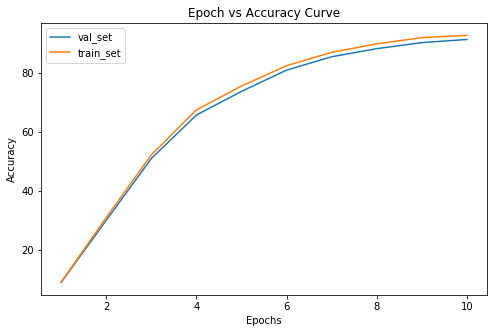

In [0]:
plt.figure(figsize=(8,5))
plt.title("Epoch vs Accuracy Curve")
plt.plot(range(1, epochs+1), val_acc, label="val_set")
plt.plot(range(1, epochs+1), train_acc, label="train_set")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Confusion Matrix

In [0]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
  # Compute confusion matrix
  cm = confusion_matrix(y_true, y_pred)
  # only use the labels that appear in the data
  classes = classes[unique_labels(y_true, y_pred)]

  print(cm)
  fig, ax = plt.subplots(figsize=(30,20))
  im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)

  # Show all ticks
  ax.set(xticks=np.arange(cm.shape[1]),
         yticks = np.arange(cm.shape[0]),
         # and label them with the respective list entries
         xticklabels = classes, yticklabels = classes,
         title=title,
         ylabel='True Label',
         xlabel='Predicted Label')
  # Rotate the tick labels and set their alignment
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  # loop over data dimensions and create text annotations
  fmt = 'd'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j, i, format(cm[i, j], fmt),
              ha="center", va="center",
              color="white" if cm[i,j] > thresh else "black")
  fig.tight_layout()
  return ax

In [0]:
label_numpy = label.cpu().numpy()
prediction_tensor = prediction.cpu()

all_labels = np.array(flat_list_label)

In [0]:
all_predictions_tensor = torch.tensor(flat_list_prediction)
all_predictions_array = np.array(flat_list_prediction)
#final_predictions = np.where(all_predictions_array>45, 0, all_predictions_array)
#final_predictions_tensor = torch.tensor(final_predictions)

[[597   0   0 ...   0   0   0]
 [  0 590   2 ...   0   2   0]
 [  0   0 596 ...   0   0   0]
 ...
 [  0   0   0 ... 600   0   0]
 [  0   0   0 ...   0 600   0]
 [  0   0   0 ...   0   0 596]]


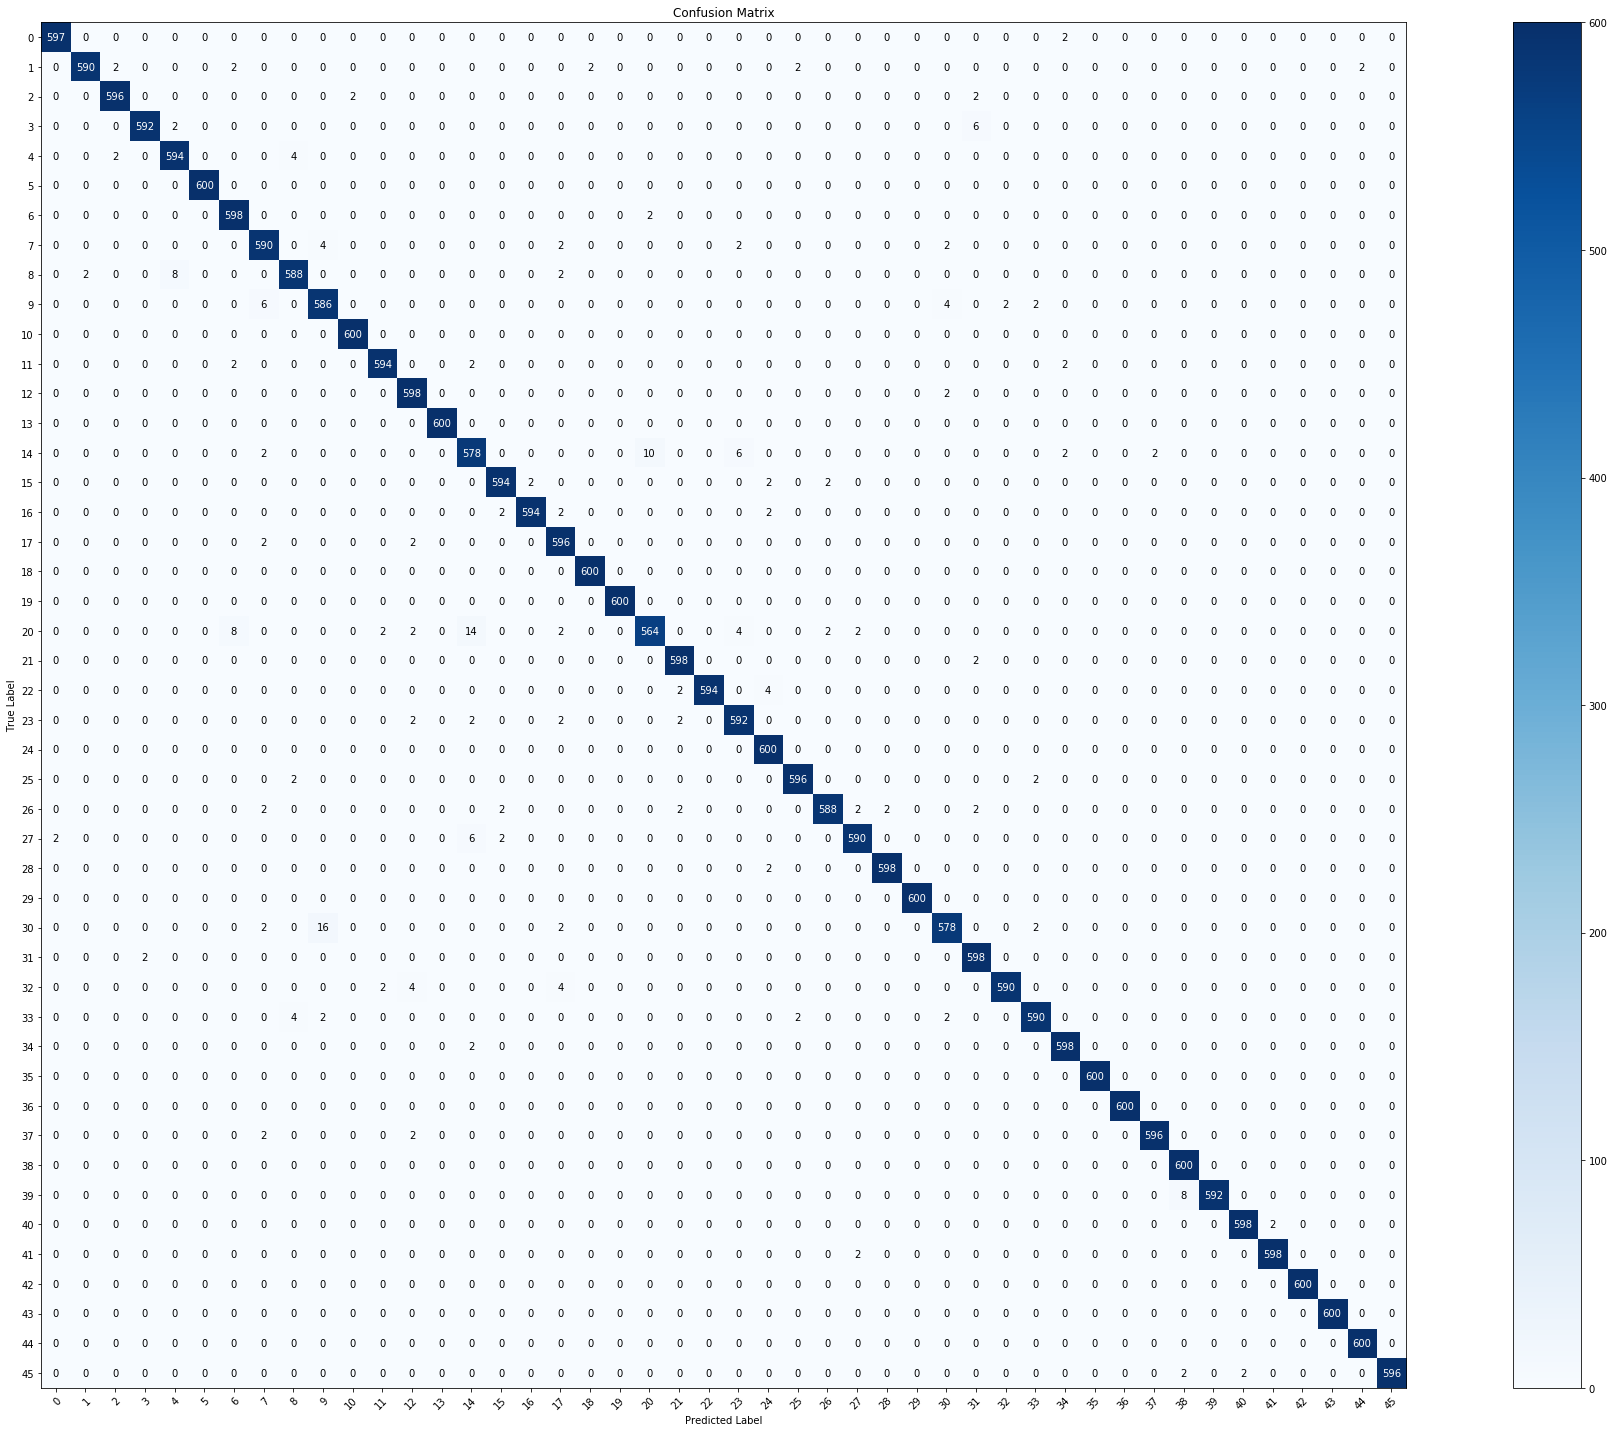

In [0]:
# Pytorch doesn't have a built-in confusion matrix metric, so we'll use Scikit-learn

from sklearn.metrics import confusion_matrix

# set the model to evaluate mode
my_model.eval()
class_names=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45]
# Get Prediction for the test data
plot_confusion_matrix(all_labels, all_predictions_tensor, np.array(class_names), title='Confusion Matrix')